# Required libraries

In [0]:
import pandas
import tqdm
import gzip
import os
import urllib.request
import pickle
import numpy
import time
import PIL.Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as dataset

import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib as mpl

# Settings

In [0]:
DATA_URL = ('https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.01/'
            'cruts.1709081022.v4.01/tmp/cru_ts4.01.1901.2016.tmp.dat.gz')
DATA_DIR = 'data'
DATA_CSV = os.path.join(DATA_DIR, 'cru_ts4.01.1901.2016.tmp.dat.gz')
DATA_PKL = os.path.join(DATA_DIR, 'cru_ts4.01.1901.2016.tmp.dat.pkl')

SAMPLE_SIZE = 519718

EPOCH = 30
BATCH_SIZE = 128
LEARNING_RATE = 0.01

# Download

available data size: (67420, 1392)


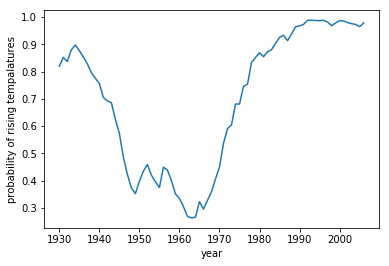

chance: 0.6983876995149614


In [0]:
class TqdmUpTo(tqdm.tqdm):
  '''copied from https://github.com/tqdm/tqdm/blob/master/examples/tqdm_wget.py'''

  def update_to(self, b=1, bsize=1, tsize=None):
    if tsize is not None:
      self.total = tsize
    self.update(b * bsize - self.n)


def load_data():
  os.makedirs(DATA_DIR, exist_ok=True)

  # download
  if not os.path.isfile(DATA_CSV):
    with TqdmUpTo(unit='B', unit_scale=True,
                  unit_divisor=1024, desc=os.path.basename(DATA_CSV)) as t:
      urllib.request.urlretrieve(DATA_URL, DATA_CSV, reporthook=t.update_to)

  # make data file (remove invalid data)
  if not os.path.isfile(DATA_PKL):
    with gzip.open(DATA_CSV, 'r') as reader:
      data = pandas.read_csv(reader, delim_whitespace=True, header=None).values

    data = data.reshape((-1, 360 * 720))
    data = data[:, ((data == -999).sum(axis=0)) == 0].transpose().astype("int32")

    with open(DATA_PKL, 'wb') as writer:
      pickle.dump(data, writer)

  with open(DATA_PKL, 'rb') as reader:
    return pickle.load(reader)

data = load_data()
data = (data - data.min()) * (1.0 / (data.max() - data.min()))
print('available data size:', data.shape)

year_mean = data.reshape(data.shape[0], -1, 12)
year_mean = numpy.average(year_mean, axis=2)

future_mean = signal.convolve2d(
  year_mean[:, 30:], numpy.ones((1, 10)) / 10, mode='valid')

past_mean = signal.convolve2d(
  year_mean[:, :-10], numpy.ones((1, 30)) / 30, mode='valid')
chance = (future_mean > past_mean).astype(numpy.float)
chance = numpy.average(chance, axis=0)

plt.plot(range(1930, 2007), chance)
plt.xlabel('year')
plt.ylabel('probability of rising tempalatures')
plt.show()

print('chance:', numpy.average(chance))

# Dataset

train data size: 389789
valid data size: 129929


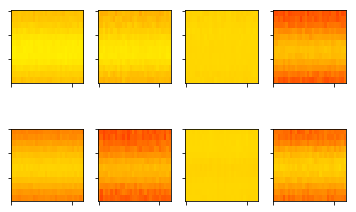

In [0]:
class Dataset(dataset.Dataset):

  def __init__(self, data, indices):
    self.data = data
    self.indices = indices

  def __len__(self):
    return len(self.indices)

  def __getitem__(self, idx):
    pos = self.indices[idx] % self.data.shape[0]
    year = self.indices[idx] // self.data.shape[0]
    past = self.data[pos, (year + 0) * 12:(year + 30) * 12]
    future = self.data[pos, (year + 30) * 12:(year + 40) * 12]
    target = 1 if numpy.average(future) > numpy.average(past) else 0

    # resize to 60x60
    img = past.reshape(-1, 12)
    img = PIL.Image.fromarray(img)
    img = img.resize((60, 60), resample=PIL.Image.NEAREST)
    img = numpy.array(img).T

    # heat color
    r = numpy.ones_like(img)
    g = img
    b = numpy.zeros_like(img)
    img = numpy.stack([r, g, b], axis=0)

    return img, target

  
numpy.random.seed(0)

indices = numpy.random.choice(
  data.shape[0] * (data.shape[1] // 12 - 39), SAMPLE_SIZE, replace=False)

train_dataset = Dataset(data, indices[len(indices) // 4:])
valid_dataset = Dataset(data, indices[:len(indices) // 4])

print('train data size:', len(train_dataset))
print('valid data size:', len(valid_dataset))

for i in range(8):
  image = train_dataset[i][0]
  image = numpy.rollaxis(image, 0, 3)

  plt.subplot(2, 4, i + 1)
  plt.tick_params(
    labelbottom=False, labelleft=False, labelright=False, labeltop=False)
  plt.imshow(image)

plt.show()

# Model

In [0]:
class LeNet(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv = nn.Sequential(
      nn.Conv2d(3, 6, kernel_size=5),
      nn.Tanh(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(6, 16, kernel_size=5),
      nn.Tanh(),
      nn.MaxPool2d(kernel_size=2, stride=2))

    self.full = nn.Sequential(
      nn.Linear(16 * 12 * 12, 120),
      nn.Tanh(),
      nn.Linear(120, 84),
      nn.Tanh(),
      nn.Linear(84, 2))

  def forward(self, x):
    x = self.conv(x)
    x = x.view(x.size(0), -1)
    x = self.full(x)

    return x


model = LeNet()

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print('model size:', sum(p.numel() for p in model.parameters()))

model size: 289806


# Training

In [0]:
class AverageMeter(object):

  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count


def accuracy(output, target):
  with torch.no_grad():
    return output.argmax(dim=1).eq(target).float().sum() / target.size(0)


def perform(model, loader, optimizer=None):
  loss_avg = AverageMeter()
  acc_avg = AverageMeter()

  for x, t in loader:
    x = x.cuda(non_blocking=True)
    t = t.cuda(non_blocking=True)

    # forward
    y = model(x)

    loss = criterion(y, t)
    acc = accuracy(y, t)

    # update parameters
    if optimizer is not None:
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # update results
    loss_avg.update(float(loss), x.size(0))
    acc_avg.update(float(acc), x.size(0))

  return loss_avg.avg, acc_avg.avg


model = model.cuda()
criterion = criterion.cuda()

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True

train_loader = dataset.DataLoader(
  train_dataset, batch_size=BATCH_SIZE, shuffle=True,
  pin_memory=True, num_workers=2)

valid_loader = dataset.DataLoader(
  valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
  pin_memory=True, num_workers=2)

schesuler = optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCH)

train_time = AverageMeter()
valid_time = AverageMeter()
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(EPOCH):
  schesuler.step()

  start_time = time.time()
  model.train()
  loss, acc = perform(model, train_loader, optimizer)
  train_loss.append(loss)
  train_acc.append(acc)
  train_time.update(time.time() - start_time)
  print('[{}] train: loss={:.4f}, accuracy={:.4f}'.format(epoch, loss, acc))

  start_time = time.time()
  model.eval()
  with torch.no_grad():
    loss, acc = perform(model, valid_loader)
  valid_loss.append(loss)
  valid_acc.append(acc)
  valid_time.update(time.time() - start_time)
  print('[{}] valid: loss={:.4f}, accuracy={:.4f}'.format(epoch, loss, acc))

print('train time/epoch: {:.4f} sec'.format(train_time.avg))
print('valid time/epoch: {:.4f} sec'.format(valid_time.avg))

[0] train: loss=0.6116, accuracy=0.6975
[0] valid: loss=0.6102, accuracy=0.6980
[1] train: loss=0.6094, accuracy=0.6975
[1] valid: loss=0.6068, accuracy=0.6980
[2] train: loss=0.6026, accuracy=0.6995
[2] valid: loss=0.5942, accuracy=0.6982
[3] train: loss=0.5743, accuracy=0.7145
[3] valid: loss=0.7358, accuracy=0.6692
[4] train: loss=0.5399, accuracy=0.7383
[4] valid: loss=0.5190, accuracy=0.7472
[5] train: loss=0.5151, accuracy=0.7517
[5] valid: loss=0.5184, accuracy=0.7530
[6] train: loss=0.4966, accuracy=0.7621
[6] valid: loss=0.4844, accuracy=0.7716
[7] train: loss=0.4777, accuracy=0.7741
[7] valid: loss=0.5163, accuracy=0.7517
[8] train: loss=0.4583, accuracy=0.7862
[8] valid: loss=0.4410, accuracy=0.7971
[9] train: loss=0.4364, accuracy=0.7999
[9] valid: loss=0.4322, accuracy=0.8022
[10] train: loss=0.4121, accuracy=0.8134
[10] valid: loss=0.4088, accuracy=0.8135
[11] train: loss=0.3894, accuracy=0.8249
[11] valid: loss=0.3770, accuracy=0.8326
[12] train: loss=0.3720, accuracy=0.

# Result

train: loss=0.2884, accuracy=0.8762
valid: loss=0.2907, accuracy=0.8749


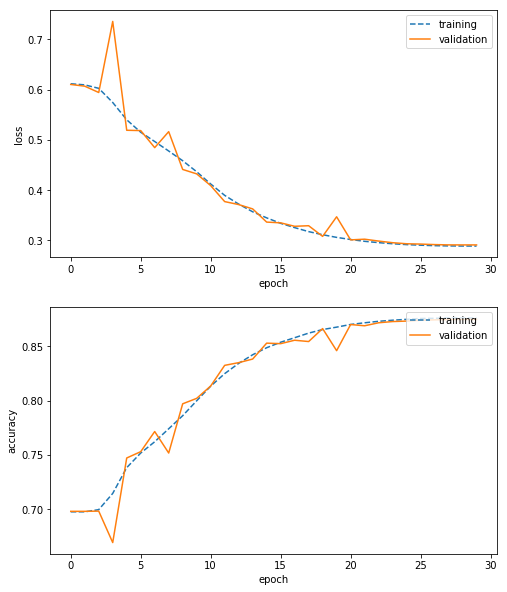

In [0]:
print('train: loss={:.4f}, accuracy={:.4f}'.format(train_loss[-1], train_acc[-1]))
print('valid: loss={:.4f}, accuracy={:.4f}'.format(valid_loss[-1], valid_acc[-1]))

figure = plt.figure(figsize=(8, 10))
axis_loss, axis_acc = figure.subplots(2, 1)
mpl.rcParams["legend.loc"] = 'upper right'

axis_loss.set_xlabel('epoch')
axis_loss.set_ylabel('loss')
axis_loss.plot(range(len(train_loss)), train_loss, linestyle='--', label='training')
axis_loss.plot(range(len(valid_loss)), valid_loss, linestyle='-', label='validation')
axis_loss.legend()

axis_acc.set_xlabel('epoch')
axis_acc.set_ylabel('accuracy')
axis_acc.plot(range(len(train_acc)), train_acc, linestyle='--', label='training')
axis_acc.plot(range(len(valid_acc)), valid_acc, linestyle='-', label='validation')
axis_acc.legend()

plt.show()